In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

from sklearn.metrics import accuracy_score

from numpy.random import seed
seed(7)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [2]:
df = pd.read_csv("combined_sampled_df.csv") 
df.head(n=5)

,Unnamed: 0,_time,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally,Success
0,0,2023-09-19T14:21:53.393Z,1,0,0,1857,11866,1693,2390,2640,11855,0,1
1,1,2023-09-19T14:21:54.508Z,1,0,0,1867,11948,1666,2388,2599,11863,0,1
2,2,2023-09-19T14:21:55.381Z,1,0,0,1870,11964,1700,2391,2612,11938,0,1
3,3,2023-09-19T14:21:56.376Z,1,0,0,1885,11913,1687,2382,2637,11974,0,1
4,4,2023-09-19T14:21:57.384Z,1,0,0,1885,11974,1677,2376,2426,11782,0,1


In [3]:
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,_time,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally,Success
0,0,2023-09-19T14:21:53.393Z,1,0,0,1857,11866,1693,2390,2640,11855,0,1
1,1,2023-09-19T14:21:54.508Z,1,0,0,1867,11948,1666,2388,2599,11863,0,1
2,2,2023-09-19T14:21:55.381Z,1,0,0,1870,11964,1700,2391,2612,11938,0,1
3,3,2023-09-19T14:21:56.376Z,1,0,0,1885,11913,1687,2382,2637,11974,0,1
4,4,2023-09-19T14:21:57.384Z,1,0,0,1885,11974,1677,2376,2426,11782,0,1


In [4]:
df['Success'].value_counts()


1    21229
0      375
Name: Success, dtype: int64

In [6]:
df['Anomally'] = df['Anomally'].replace({'N': 0, 'Y': 1})
df
df=df.rename(columns={"Success?": "Success"})

df['Success'] = df['Success'].replace({'N': 0, 'Y': 1})
df

,Unnamed: 0,_time,GreenRocket,Door1,Door2,LoadCell_R02,Potentiometer_R02,LoadCell_R03,Potentiometer_R03,LoadCell_R04,Potentiometer_R04,Anomally,Success
0,0,2023-09-19T14:21:53.393Z,1,0,0,1857,11866,1693,2390,2640,11855,0,1
1,1,2023-09-19T14:21:54.508Z,1,0,0,1867,11948,1666,2388,2599,11863,0,1
2,2,2023-09-19T14:21:55.381Z,1,0,0,1870,11964,1700,2391,2612,11938,0,1
3,3,2023-09-19T14:21:56.376Z,1,0,0,1885,11913,1687,2382,2637,11974,0,1
4,4,2023-09-19T14:21:57.384Z,1,0,0,1885,11974,1677,2376,2426,11782,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21599,21599,2023-09-19T20:21:55.676Z,0,0,0,1883,2051,1653,2382,1568,11815,1,0
21600,21600,2023-09-19T20:21:56.679Z,0,0,0,1863,2066,1678,2382,2629,11959,1,0
21601,21601,2023-09-19T20:21:57.682Z,0,0,0,1880,2059,1682,2401,2729,12059,1,0
21602,21602,2023-09-19T20:21:58.697Z,0,0,0,1863,2064,1698,2410,2627,11944,1,0


In [8]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    vector = df['Anomally'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'Anomally'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [9]:
'''
Shift the data by 4 units

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['Anomally'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 20 rows.
df = curve_shift(df, shift_by = -70)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,Unnamed: 0,_time,GreenRocket,Door1,Door2
1572,1572,2023-09-19T14:48:05.388Z,0,0,0
1573,1573,2023-09-19T14:48:06.390Z,0,0,0
1574,1574,2023-09-19T14:48:07.380Z,0,0,0
1575,1575,2023-09-19T14:48:08.409Z,0,0,1
1576,1576,2023-09-19T14:48:09.394Z,0,0,1


After shifting


,Anomally,Unnamed: 0,_time,GreenRocket,Door1
1571,1.0,1571,2023-09-19T14:48:04.388Z,0,0
1572,1.0,1572,2023-09-19T14:48:05.388Z,0,0
1573,1.0,1573,2023-09-19T14:48:06.390Z,0,0
1574,1.0,1574,2023-09-19T14:48:07.380Z,0,0
1586,0.0,1586,2023-09-19T14:48:19.986Z,0,0


In [10]:
# Remove time column, and the categorical columns
df = df.drop(['_time'], axis=1)

In [11]:
df = df.drop(['Unnamed: 0'], axis=1)

In [12]:
df=df.drop(['Success'], axis=1)

In [13]:
X = df.drop(['Anomally'], axis=1)

y = df['Anomally']

In [14]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
18884    1.0
18885    1.0
18886    1.0
18887    1.0
18888    1.0
Name: Anomally, Length: 18183, dtype: float64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((14546, 9), (3637, 9))

In [17]:
df['Anomally'].value_counts()

0.0    17560
1.0      623
Name: Anomally, dtype: int64

In [18]:
y_train

4922     0.0
13175    0.0
16238    0.0
4144     0.0
15090    0.0
        ... 
9642     0.0
13816    0.0
10262    0.0
11216    0.0
2743     0.0
Name: Anomally, Length: 14546, dtype: float64

In [19]:
# Feature scaling

In [20]:
cols = X_train.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])


In [21]:
# define model
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.65740


In [22]:
model = XGBClassifier()

clf_0 = model.fit(X_train, y_train)


In [23]:
pred_y_0 = clf_0.predict(X_test)

print(accuracy_score(pred_y_0, y_test))



0.9670057739895518


In [24]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_0, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_0)

              precision    recall  f1-score   support

     class 0       0.97      1.00      0.98      3516
     class 1       0.55      0.05      0.09       121

    accuracy                           0.97      3637
   macro avg       0.76      0.52      0.54      3637
weighted avg       0.95      0.97      0.95      3637



array([[3511,    5],
       [ 115,    6]])

# Weighted XGBoost for Class Imbalance


In [25]:
# define model
#scale_pos_weight=total_negative_examples / total_positive_examples
#total number of examples in the majority class / total number of examples in the minority class.
#21604/3421=6.3
model = XGBClassifier(scale_pos_weight=6.3)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.64517


In [26]:
clf_1 = model.fit(X_train, y_train)
pred_y_1 = clf_1.predict(X_test)

print(accuracy_score(pred_y_1, y_test))

0.9593071212537806


In [27]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_1, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_1)

              precision    recall  f1-score   support

     class 0       0.97      0.99      0.98      3516
     class 1       0.19      0.07      0.10       121

    accuracy                           0.96      3637
   macro avg       0.58      0.53      0.54      3637
weighted avg       0.94      0.96      0.95      3637



array([[3481,   35],
       [ 113,    8]])

# Tune with GridSearch CV

In [28]:
# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [33]:
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/chathurangishyalika/opt/anaconda3/envs/tf/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:30] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.931436 using {'scale_pos_weight': 1}
0.931436 (0.040774) with: {'scale_pos_weight': 1}
0.927670 (0.048305) with: {'scale_pos_weight': 10}
0.929479 (0.045071) with: {'scale_pos_weight': 25}
0.922069 (0.046362) with: {'scale_pos_weight': 50}
0.923126 (0.051366) with: {'scale_pos_weight': 75}
0.922714 (0.053929) with: {'scale_pos_weight': 99}
0.922413 (0.053952) with: {'scale_pos_weight': 100}
0.905774 (0.058887) with: {'scale_pos_weight': 1000}


In [52]:
# define model
model = XGBClassifier(scale_pos_weight=25)

# define evaluation procedure
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
#scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.64517


In [53]:
clf_2 = model.fit(X_train, y_train)
pred_y_2 = clf_2.predict(X_test)

print(accuracy_score(pred_y_2, y_test))


0.9254880395930712


In [54]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred_y_2, target_names=target_names))

# View confusion matrix for test data and predictions
confusion_matrix(y_test, pred_y_2)

              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      3516
     class 1       0.10      0.16      0.12       121

    accuracy                           0.93      3637
   macro avg       0.54      0.55      0.54      3637
weighted avg       0.94      0.93      0.93      3637



array([[3347,  169],
       [ 102,   19]])

<AxesSubplot:>

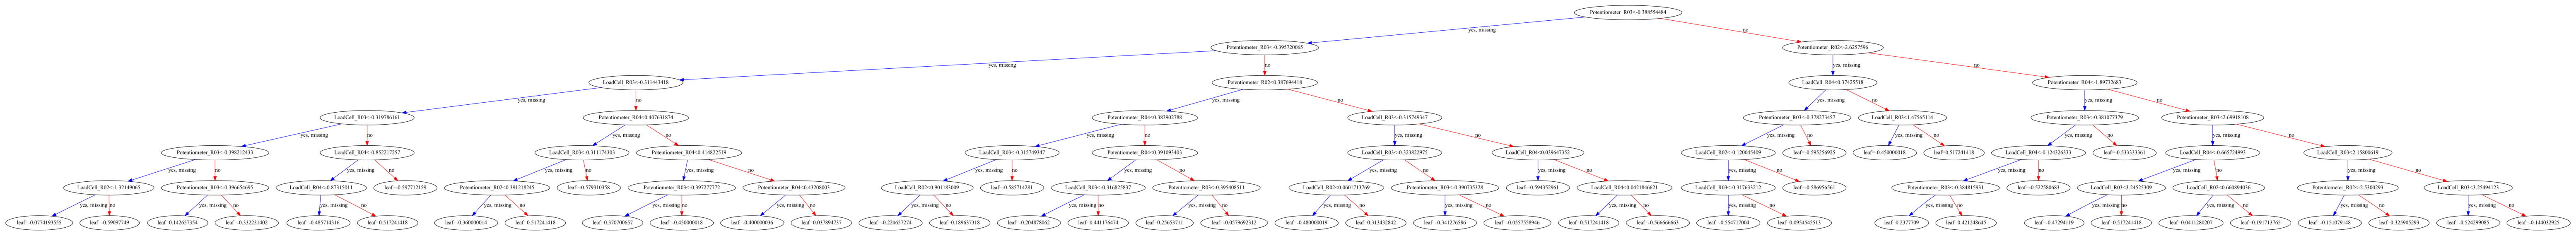

In [55]:
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50

plot_tree(model)
#yes, missing here means this tree has handled missing values